## Libraries
- yfinance: We used it to pull EURUSD data.
- pandas: We used it for data analysis.
- numpy: We used it for various mathematical functions.
- matplotlib: We used it for plotting graphs.
- seaborn: We used it to draw various graphs.
- tensorflow: We used it for machine learning.
- sklearn: We used it for machine learning.

In [108]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Data

- Between 1 January 2005 and 1 May 2024, we imported daily and monthly EURUSD price data via yfinance.

- We imported SP500 data via yfinance.

- We uploaded STOXX50E data as csv file.

In [109]:
# get the data of eurusd for given range
start_date = '2005-01-01'
end_date = '2024-05-01'

eur_usd_data_daily = yf.download('EURUSD=X', start=start_date, end=end_date)
eur_usd_data_monthly = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1mo')

GSPC_data_monthly = yf.download('^GSPC', start='2004-12-01', end=end_date, interval='1mo')
STOXX50E_data_monthly = pd.read_csv('csv_files/STOXX50E.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


* We calculated the daily price change as ROI.

In [110]:
eur_usd_pct_change = eur_usd_data_daily['Close'].pct_change()

eur_usd_data_monthly.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-01,1.356594,1.362695,1.293193,1.305193,1.305193,0
2005-02-01,1.305006,1.328004,1.273707,1.321702,1.321702,0
2005-03-01,1.321895,1.347909,1.286107,1.296697,1.296697,0
2005-04-01,1.296798,1.311699,1.277906,1.292307,1.292307,0
2005-05-01,1.292307,1.298701,1.229997,1.230800,1.230800,0


## Volatility

- We calculated the monthly volatility from the daily change by adjusting the daily data monthly.

In [111]:
# create a new dataframe to store the monthly data, indexes should be at the format: "2005-01"
feature_set = pd.DataFrame(index=eur_usd_data_daily.resample('M').mean().index.strftime('%Y-%m'), columns=['volatility'])

# calculate the volatility for each month
for month in feature_set.index:
    start_date = month
    end_date = pd.to_datetime(start_date) + pd.DateOffset(months=1)
    feature_set.loc[month] = round((eur_usd_pct_change.loc[start_date:end_date].std()) * (len(eur_usd_pct_change.loc[start_date:end_date]) ** (1/2)) * 100, 3)

feature_set['volatility'] = feature_set['volatility'].astype(float) 
# print the monthly data
feature_set.head(10)

,volatility
Date,
2005-01,2.668
2005-02,2.477
2005-03,2.774
2005-04,2.162
2005-05,2.793
2005-06,3.202
2005-07,2.991
2005-08,2.640
2005-09,2.284


- Histogram of the monthly volatility

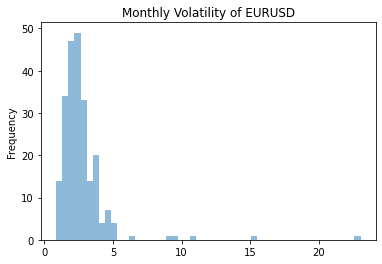

In [112]:
# make a histogram of the monthly volatility
feature_set['volatility'].plot.hist(bins=50, alpha=0.5, title='Monthly Volatility of EURUSD')
plt.show()

- We've calculated mean and std of the monthly volatility so we can choose a threshold.

In [113]:
# mean and standard deviation of the monthly volatility
mean = feature_set.volatility.mean()
std = feature_set.volatility.std()
print('Mean:', mean)
print('Standard Deviation:', std)

Mean: 2.735749999999999
Standard Deviation: 2.0091483641957972


- We've set a threshold to classify the data as low/high volatility

In [114]:
# print the ncount of the rows that are smaller than the mean + 1 std
threshold = 2.5
print(f'Number of months that have volatility smaller than {threshold}:', len(feature_set[feature_set.volatility < threshold]))

Number of months that have volatility smaller than 2.5: 130


- We categorised those with volatility higher than the threshold as 1 (high) and those with volatility lower than the threshold as 0 (low).

In [115]:
# add a low/high column that labels the month as low or high volatility according to the threshold
feature_set['low/high'] = np.where(feature_set.volatility < threshold, 0, 1)
feature_set['low/high'] = feature_set['low/high'].shift(-1)

# print the monthly data with the low/high column
feature_set.head(10)

,volatility,low/high
Date,,
2005-01,2.668,0.0
2005-02,2.477,1.0
2005-03,2.774,0.0
2005-04,2.162,1.0
2005-05,2.793,1.0
2005-06,3.202,1.0
2005-07,2.991,1.0
2005-08,2.640,0.0
2005-09,2.284,1.0


## Adding new features

In [116]:
# add the percentage change of the previous month
feature_set['abs_pct_change_monthly'] = abs(np.array(eur_usd_data_monthly['Close'].pct_change()))

In [117]:
# add max_abs_return_daily
current_month = eur_usd_data_daily.index[0].strftime('%Y-%m')
prices = []
pct_dict = {}

for idx, daily in eur_usd_data_daily.iterrows():
    if current_month != idx.strftime('%Y-%m'):
        pct_dict[current_month] = max(abs(pd.Series(prices).pct_change().max()), abs(pd.Series(prices).pct_change().min()))
        prices = []
        current_month = idx.strftime('%Y-%m')
    else:
        prices.append(daily["Close"])

feature_set['max_abs_return_daily'] = feature_set.index.map(pct_dict)

# add the fedfunds.csv file
# https://fred.stlouisfed.org/series/FEDFUNDS
fed_funds = pd.read_csv('csv_files/FEDFUNDS.csv')
feature_set['fed_funds'] = np.array(fed_funds[fed_funds["DATE"] > "2004-11-31"]['FEDFUNDS'])[1:]

# add the 10 year treasury rate
# https://fred.stlouisfed.org/series/GS10
ten_year_treasury = pd.read_csv('csv_files/GS10.csv')
feature_set['10_year_treasury'] = np.array(ten_year_treasury[ten_year_treasury["DATE"] > "2004-11-10"]['GS10'])[1:]

# add ecb interest rate
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/ecb-interest-rates-626986
ecb_interest = pd.read_csv('csv_files/ECBRATES.csv', header=None)
feature_set['ecb_interest'] = np.array(ecb_interest[ecb_interest[0] > "2004-12-31"][1])

# add the interest rate difference between ecb and fed
feature_set['interest_diff'] = abs(feature_set['ecb_interest'] - feature_set['fed_funds'])

# add the monthly return of the S&P 500
feature_set['sp500_return'] = np.array(GSPC_data_monthly['Close'].pct_change())[1:]

# add the monthly return of the STOXX 50
# https://www.investing.com/indices/eu-stoxx50-historical-data
feature_set['stoxx50_return'] = np.array(STOXX50E_data_monthly[STOXX50E_data_monthly["DATE"] > "2004-11-31"]['VALUES'].pct_change())[1:]

# add the difference between the S&P 500 and STOXX 50 returns
feature_set['sp500_stoxx50_diff'] = abs(feature_set['sp500_return'] - feature_set['stoxx50_return'])

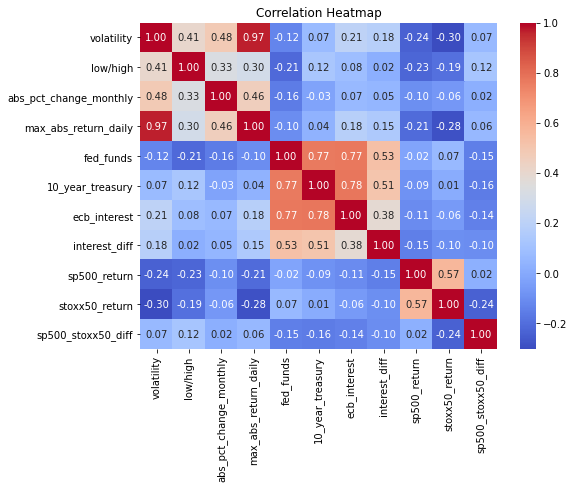

In [118]:
# Generate correlation matrix
correlation_matrix = feature_set.corr()

# Generate heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [119]:
feature_set.dropna(inplace=True)
feature_set.head()

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily,fed_funds,10_year_treasury,ecb_interest,interest_diff,sp500_return,stoxx50_return,sp500_stoxx50_diff
Date,,,,,,,,,,,
2005-02,2.477,1.0,0.012649,0.015078,2.50,4.17,2.0,0.50,0.018903,0.031585,0.012681
2005-03,2.774,0.0,0.018919,0.012082,2.63,4.50,2.0,0.63,-0.019118,0.005031,0.024148
2005-04,2.162,1.0,0.003386,0.011495,2.79,4.34,2.0,0.79,-0.020109,-0.016968,0.003141
2005-05,2.793,1.0,0.047595,0.014019,3.00,4.14,2.0,1.00,0.029952,0.003226,0.026726
2005-06,3.202,1.0,0.017629,0.014870,3.04,4.00,2.0,1.04,-0.000143,0.042400,0.042542


0.00032509938951030826
0.1622233824825492
0.03094528603785334


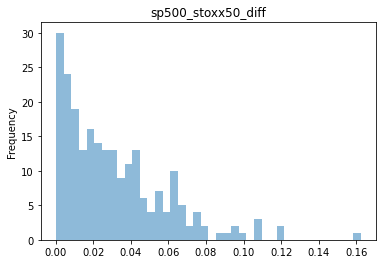

In [129]:
feat = "sp500_stoxx50_diff"
print(feature_set[feat].min())
print(feature_set[feat].max())
#mean
print(feature_set[feat].mean())

hst = 1
p = 0
# make histogram of the feature
if hst:
    feature_set[feat].plot.hist(bins=40, alpha=0.5, title=feat)
    plt.show()

# make time series plot of the feature
if p:
    feature_set[feat].plot(title=feat)
    plt.show()

In [74]:
# Randomize the data
feature_set = feature_set.sample(frac=1)

x_data = feature_set.drop(columns=['volatility', 'low/high', 'max_abs_return_daily'], axis=1)
y_data = feature_set['low/high']

x_data.corr()

,abs_pct_change_monthly,fed_funds,10_year_treasury,ecb_interest,interest_diff,sp500_return,stoxx50_return,sp500_stoxx50_diff
abs_pct_change_monthly,1.000000,-0.151775,-0.021272,0.075592,0.329828,-0.099960,-0.064790,-0.035775
fed_funds,-0.151775,1.000000,0.768107,0.768485,-0.619788,-0.012141,0.067023,-0.086015
10_year_treasury,-0.021272,0.768107,1.000000,0.778375,-0.245371,-0.078562,0.009396,-0.093892
ecb_interest,0.075592,0.768485,0.778375,1.000000,0.025850,-0.096040,-0.057179,-0.039902
interest_diff,0.329828,-0.619788,-0.245371,0.025850,1.000000,-0.098821,-0.174837,0.085444
sp500_return,-0.099960,-0.012141,-0.078562,-0.096040,-0.098821,1.000000,0.569648,0.443505
stoxx50_return,-0.064790,0.067023,0.009396,-0.057179,-0.174837,0.569648,1.000000,-0.483994
sp500_stoxx50_diff,-0.035775,-0.086015,-0.093892,-0.039902,0.085444,0.443505,-0.483994,1.000000


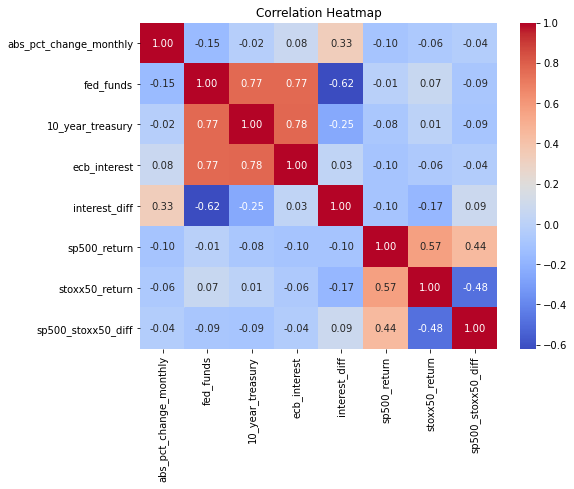

In [14]:
# Generate correlation matrix
correlation_matrix = x_data.corr()

# Generate heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [15]:
x_data = np.array(x_data)
y_data = np.array(y_data)

## Helper Functions

In [ ]:
# k-folds cross validation function
def k_folds_cross_validation(x_data, y_data, model_func, k=5):
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    fold_size = len(x_data) // k
    accuracies = []
    models = []

    test_data = []

    for i in range(k):
        x_train = np.concatenate([x_data[:i * fold_size], x_data[(i + 1) * fold_size:]])
        y_train = np.concatenate([y_data[:i * fold_size], y_data[(i + 1) * fold_size:]])
        x_test = x_data[i * fold_size:(i + 1) * fold_size]
        y_test = y_data[i * fold_size:(i + 1) * fold_size]

        test_data.append((x_test, y_test))

        current_model, accuracy = model_func(x_train, y_train, x_test, y_test)

        #printing confusion matrix
        y_pred = current_model.predict(x_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # labelling the confusion matrix by making a dataframe
        #cm_df = pd.DataFrame(cm, index=['Actual Low', 'Actual High'], columns=['Predicted Low', 'Predicted High'])
        #print(cm_df)
        
        models.append(current_model)
        accuracies.append(accuracy)

    return accuracies, models, test_data

In [69]:
# implement roc curve for logistic regression without using k-folds cross validation
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def print_roc_curve(models, test_data):
    for idx, model in enumerate(models):
        x_test, y_test = test_data[idx]

        y_pred_prob = model.predict(x_test)

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='r', linestyle='--', lw=2, label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

## Implementing neural network

In [66]:
def neural_network(x_train, y_train, x_test, y_test, hidden_layer=3, neurons=6, epochs=100):
    model = Sequential()
    # Add input layer
    model.add(Dense(neurons, input_dim=8, activation='relu'))

    # Add hidden layers
    for _ in range(hidden_layer):
        model.add(Dense(neurons, activation='relu'))

    # Add output layer
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer with a custom learning rate
    custom_optimizer = Adam(learning_rate=0.03)
    model.compile(loss='mse', optimizer=custom_optimizer, metrics=['accuracy'])

    current_model = model.fit(x_train, y_train, epochs=epochs, batch_size=10, verbose=0)
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)

    return model, accuracy

In [48]:
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def k_folds_cross_validation_mean_roc_curve(x_data, y_data, model_func, k=5):
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    fold_size = len(x_data) // k
    accuracies = []
    models = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    plt.figure(figsize=(10, 8))

    for i in range(k):
        # Splitting the data into training and testing sets
        x_train = np.concatenate([x_data[:i * fold_size], x_data[(i + 1) * fold_size:]])
        y_train = np.concatenate([y_data[:i * fold_size], y_data[(i + 1) * fold_size:]])
        x_test = x_data[i * fold_size:(i + 1) * fold_size]
        y_test = y_data[i * fold_size:(i + 1) * fold_size]

        # Training the model and getting accuracy
        current_model, accuracy = model_func(x_train, y_train, x_test, y_test)

        # Making predictions
        y_pred_prob = current_model.predict(x_test)  # probabilities for the positive class
        y_pred = (y_pred_prob > 0.5)
        
        # Printing confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for fold {i+1}:\n", cm)

        # Calculating ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        # Plotting the ROC curve for the current fold
        #plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

        models.append(current_model)
        accuracies.append(accuracy)

    # Plotting the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f})')

    # Plotting the chance line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Chance')

    # Finalizing the plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

    return accuracies, models
"""

2/2 [==============================] - 0s 2ms/step
[[21  3]
 [ 6 16]]
2/2 [==============================] - 0s 2ms/step
[[23  3]
 [12  8]]
2/2 [==============================] - 0s 2ms/step
[[14 14]
 [ 1 17]]
2/2 [==============================] - 0s 2ms/step
[[24  2]
 [11  9]]
2/2 [==============================] - 0s 2ms/step
[[24  1]
 [11 10]]
Accuracies: [0.804347813129425, 0.6739130616188049, 0.6739130616188049, 0.717391312122345, 0.739130437374115]
Mean Accuracy: 0.721739137172699
2/2 [==============================] - 0s 3ms/step


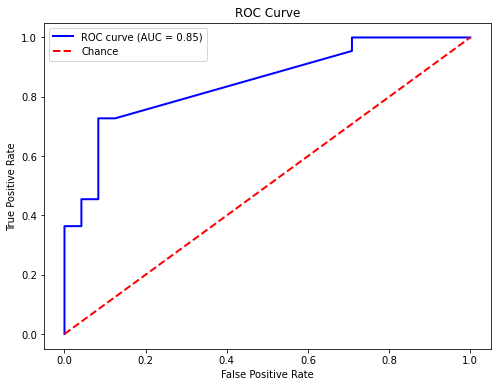

2/2 [==============================] - 0s 3ms/step


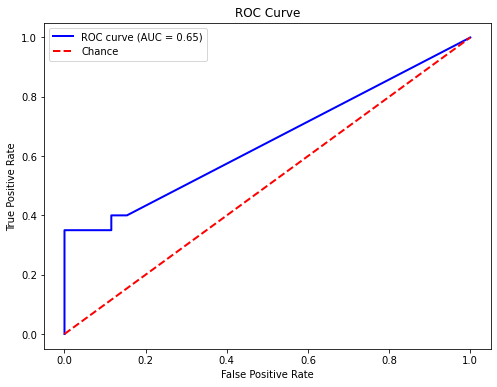

2/2 [==============================] - 0s 1ms/step


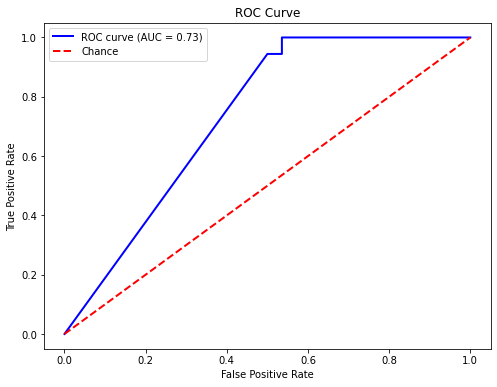

2/2 [==============================] - 0s 2ms/step


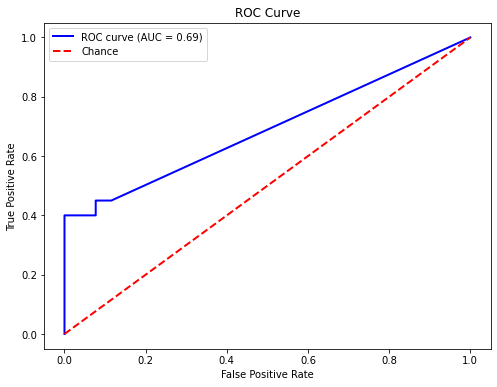

2/2 [==============================] - 0s 2ms/step


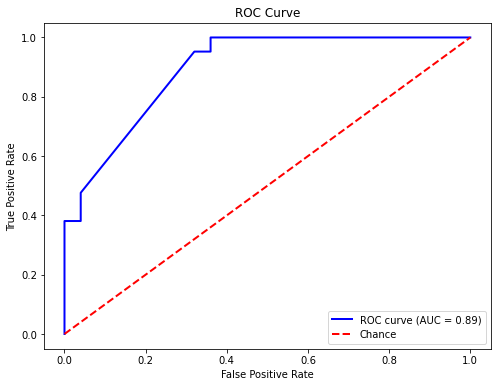

In [75]:
accr, models, test_data = k_folds_cross_validation(x_data, y_data, neural_network)
print('Accuracies:', accr)
print('Mean Accuracy:', np.mean(accr))

# give roc curves for every model
print_roc_curve(models, test_data)

In [20]:
predict = pd.DataFrame(model.predict(x_test))
predict.to_excel('results/predict.xlsx', index=False)

NameError: name 'model' is not defined

In [ ]:
true = pd.DataFrame(y_test)
true.to_excel('results/true.xlsx', index=False)

## Implementing Logistic Regression

In [82]:
# Implementing logistic regression function to use in k-folds cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def logistic_regression(x_train, y_train, x_test, y_test):
    model = LogisticRegression(max_iter=1000, C=0.1, solver='lbfgs')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, accuracy

[[19  5]
 [ 5 17]]
[[23  3]
 [12  8]]
[[20  8]
 [ 7 11]]
[[21  5]
 [11  9]]
[[22  3]
 [11 10]]
Accuracies: [0.782608695652174, 0.6739130434782609, 0.6739130434782609, 0.6521739130434783, 0.6956521739130435]
Mean Accuracy: 0.6956521739130435


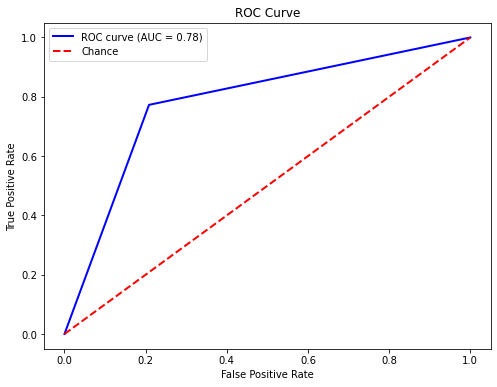

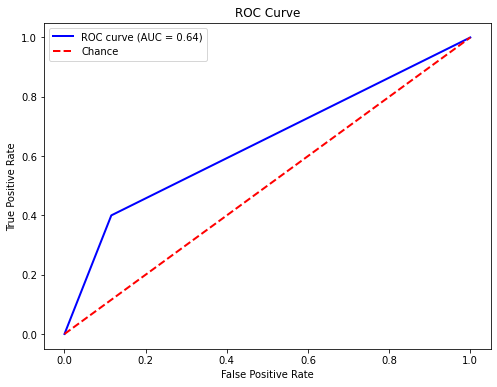

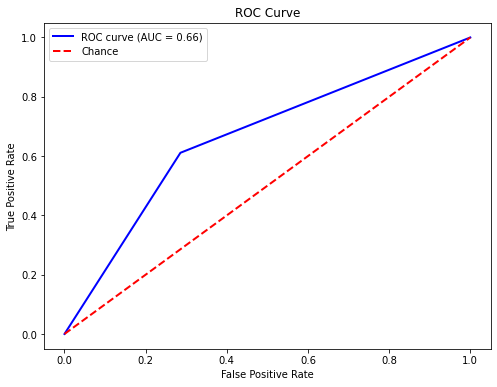

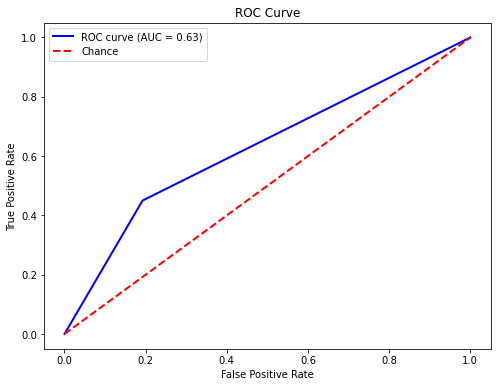

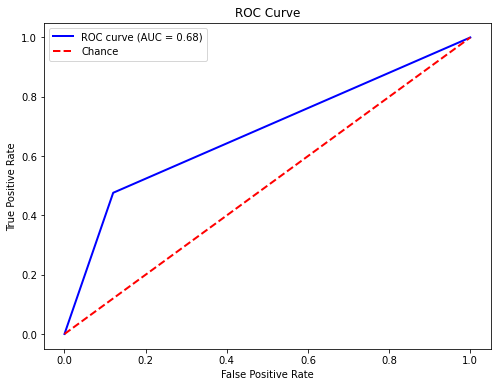

In [83]:
# Applying k-folds cross validation to logistic regression
accr, models, test_data = k_folds_cross_validation(x_data, y_data, logistic_regression)
print('Accuracies:', accr)
print('Mean Accuracy:', np.mean(accr))

# give roc curves for every model
print_roc_curve(models, test_data)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89        24
         1.0       0.84      0.95      0.89        22

    accuracy                           0.89        46
   macro avg       0.90      0.89      0.89        46
weighted avg       0.90      0.89      0.89        46

ROC-AUC: 0.9186
Cross-Validated Accuracy: 0.8152
[[20  4]
 [ 1 21]]
Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        26
         1.0       1.00      0.65      0.79        20

    accuracy                           0.85        46
   macro avg       0.89      0.82      0.83        46
weighted avg       0.88      0.85      0.84        46

ROC-AUC: 0.9288
Cross-Validated Accuracy: 0.8044
[[26  0]
 [ 7 13]]
Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    

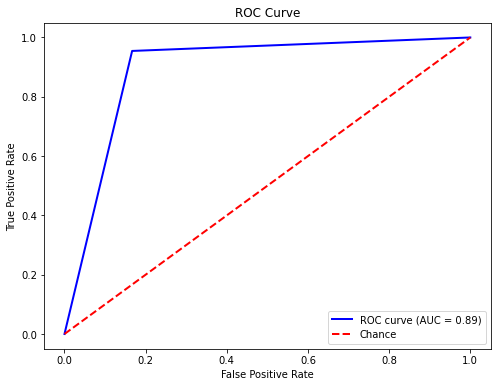

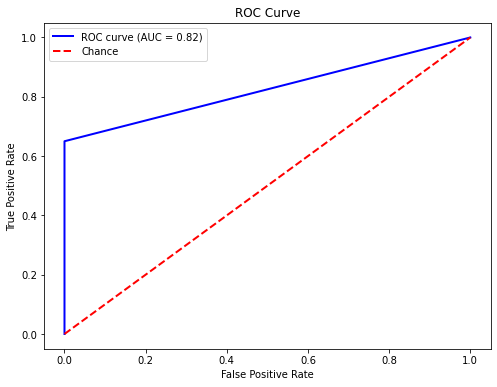

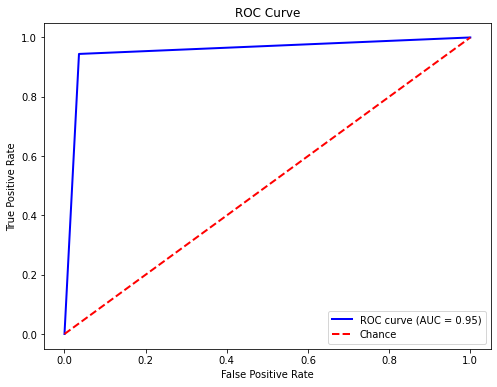

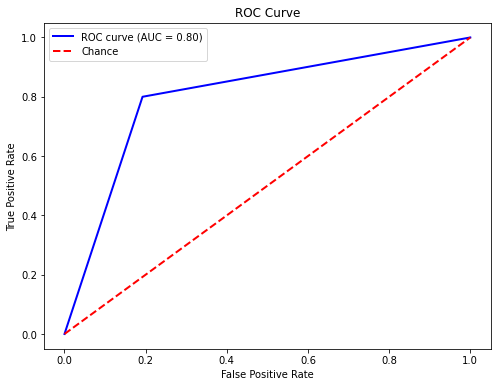

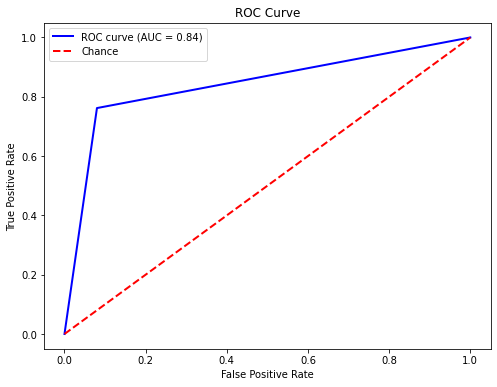

In [85]:
# Implementing random forest function to use in k-folds cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

def random_forest(x_train, y_train, x_test, y_test):
    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [None, 10, 30, 50],
    }
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_

    # Cross-validation
    cv_scores = cross_val_score(best_model, x_train, y_train, cv=5)
    mean_cv_accuracy = cv_scores.mean()

    # Predictions and evaluation
    y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_pred_prob = best_model.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Print classification report and ROC-AUC score
    print(classification_report(y_test, y_pred))
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'Cross-Validated Accuracy: {mean_cv_accuracy:.4f}')

    return best_model, accuracy

# Applying k-folds cross validation to random forest
accr, models, test_data = k_folds_cross_validation(x_data, y_data, random_forest)
print('Accuracies:', accr)
print('Mean Accuracy:', np.mean(accr))

# give roc curves for every model
print_roc_curve(models, test_data)

## SVM

[[20  4]
 [ 4 18]]
[[23  3]
 [10 10]]
[[22  6]
 [ 7 11]]
[[21  5]
 [ 9 11]]
[[22  3]
 [ 9 12]]
Accuracies: [0.8260869565217391, 0.717391304347826, 0.717391304347826, 0.6956521739130435, 0.7391304347826086]
Mean Accuracy: 0.7391304347826086


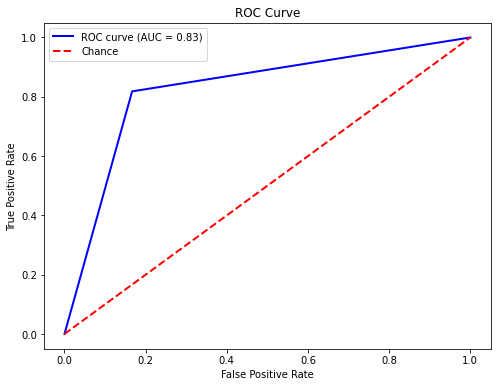

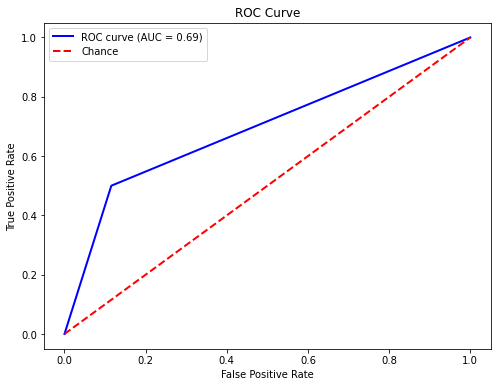

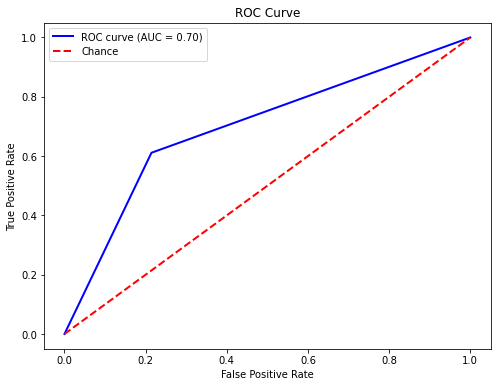

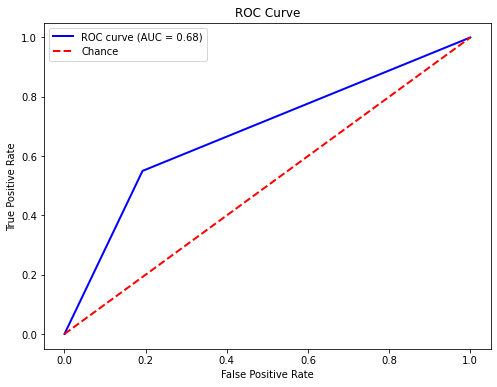

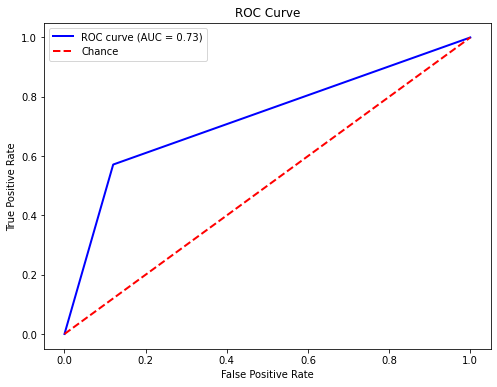

In [79]:
# Implementing svm function to use in k-folds cross validation
from sklearn.svm import SVC

def svm(x_train, y_train, x_test, y_test):
    model = SVC(probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, accuracy

# Applying k-folds cross validation to svm
accr, models, test_data = k_folds_cross_validation(x_data, y_data, svm)
print('Accuracies:', accr)
print('Mean Accuracy:', np.mean(accr))

# give roc curves for every model
print_roc_curve(models, test_data)
